# WHAT'S HERE & NEXT TODO

- Implement with Dataset - hotpot QA
- Play around with Temperature, Penalty, % above max activation coefficient. 240 was way above. But as described in the Streamlit tutorial: 
> Note that we can choose the value of steering_coefficient based on the maximum activation of the latent we're steering on (it's usually wise to choose quite close to the max activation, but not so far above that you steer the model far out of distribution - however this varies from latent to latent, e.g. in the case of this particular latent we'll find it still produces coherent output quite far above the max activation value). If we didn't have neuronpedia then we couldn't do this, and we'd be better off measuring the max activation over some suitably large dataset to guide what value to choose for our steering coefficient.

3 different steering latents (minimum)
Maybe 100 Questions.
--> Evaluation metrics ! 


## Evaluation metrics brainstorm

1. First need to see if the answer is correct, with and without steering. If the model performance is shit, even without steering it's the wrong model or dataset. 
2. Then it becomes interesting to see if the steered examples are correct. Ideally: They are more often wrong than the normal one. This would indicate model drift. 
3. At this point, it's time to look at the max activating latents and logits and compare those of the right answer, to wrong anwers. 
    For Qs where the unsteered output is already wrong -- no point further evaluating
4. Change the input? i.e make it use slang. Make it ask the Q in a different way, using yet another LLM. 

# Setup
Conda Env == lets_drift_env_V1 
(Which is a clone of arena_env1_1_1c)

In [1]:
%run LetsDriftGemma2_imports.py

starts with a j..jeje .. f_JTQGGDeycTxPCozthrzqWQhmLpOkaVKXRq
Successfully imported all the imports


#### Choose Model here

In [2]:
""" # TODO Implement chooser
if model2use == "gemma2_2b_it": 
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-2b-it")
    model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-2b-it",
    device_map="auto",
        torch_dtype=t.bfloat16,
    )
    print("gemma2_2b_it loaded")
elif model2use == "gemma2_9b_it":
    tokenizer = AutoTokenizer.from_pretrained("google/gemma-2-9b-it")
    model = AutoModelForCausalLM.from_pretrained(
    "google/gemma-2-9b-it",
    device_map="auto",
    torch_dtype=t.bfloat16,
    )
    print("gemma2_9b_it loaded")
"""
#from sae_lens import SAE

model2use = "gemma2_9b_it_131k"

if model2use == "gemma2_2b":
    model_name = "gemma-2-2b"
    gemma_2_2b = HookedSAETransformer.from_pretrained(model_name, device=device)

    gemmascope_sae_release = "gemma-scope-2b-pt-res-canonical"
    gemmascope_sae_id = "layer_20/width_16k/canonical"

    gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]
elif model2use == "gemma2_9b_it_16k":  
    model_name = "gemma-2-9b-it"
    gemma_2_2b = HookedSAETransformer.from_pretrained(model_name, device=device, dtype="float16")  # dtype float16 helps with CUDA RAM issues..
    # Fix: Remove trailing comma that creates a tuple instead of a string
    gemmascope_sae_release = "gemma-scope-9b-it-res-canonical"  # <-- Remove comma here
    gemmascope_sae_id = "layer_9/width_16k/canonical"
    gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]
# ... existing code ..
elif model2use == "gemma2_9b_it_131k":  
    model_name = "gemma-2-9b-it"
    gemma_2_2b = HookedSAETransformer.from_pretrained(model_name, device=device, dtype="float16")  # dtype float16 helps with CUDA RAM issues..
    # Fix: Remove trailing comma that creates a tuple instead of a string
    gemmascope_sae_release = "gemma-scope-9b-it-res-canonical"  # <-- Remove comma here
    gemmascope_sae_id = "layer_9/width_131k/canonical"
    gemma_2_2b_sae = SAE.from_pretrained(gemmascope_sae_release, gemmascope_sae_id, device=str(device))[0]
# ... existing code ..
else:
    raise ValueError(f"Invalid model2use value: {model2use}. Must be one of: 'gemma2_2b', 'gemma2_9b_it'")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Loaded pretrained model gemma-2-9b-it into HookedTransformer


In [3]:
from sae_lens.toolkit.pretrained_saes_directory import get_pretrained_saes_directory

# Get directory and convert to dataframe
df = pd.DataFrame.from_records(
    {k: v.__dict__ for k, v in get_pretrained_saes_directory().items()}
).T

# Filter for gemma-2-9b-it model and display saes_map
gemma_9b_saes = df[df['model'] == 'gemma-2-9b-it']
print("\nSAEs map for gemma-2-9b-it model:")
for idx, row in gemma_9b_saes.iterrows():
    print(f"\n{idx}:")
    print(row['saes_map'])


SAEs map for gemma-2-9b-it model:

gemma-scope-9b-it-res-canonical:
{'layer_9/width_16k/canonical': 'layer_9/width_16k/average_l0_88', 'layer_20/width_16k/canonical': 'layer_20/width_16k/average_l0_91', 'layer_31/width_16k/canonical': 'layer_31/width_16k/average_l0_76', 'layer_9/width_131k/canonical': 'layer_9/width_131k/average_l0_121', 'layer_20/width_131k/canonical': 'layer_20/width_131k/average_l0_81', 'layer_31/width_131k/canonical': 'layer_31/width_131k/average_l0_109'}


## CONFIG: Generate_Kwargs, Random Seed, EnaDebug

#### Necessary Functions & Utilities - GENERAL 


In [4]:
default_temp = 0.1
default_freq_penalty = 2.0
def set_KWARGS_to_default():
    global GENERATE_KWARGS  # Declare that we want to modify the global variable
    GENERATE_KWARGS = dict(temperature=default_temp, freq_penalty=default_freq_penalty, verbose=False)

GENERATE_KWARGS = dict(temperature=default_temp, freq_penalty=default_freq_penalty, verbose=False)#(temperature=0.5, freq_penalty=2.0, verbose=False)
seed_int: int = 42
t.manual_seed(seed_int)

In [5]:
%run SAE_Lens_Scripts.py
# Test that dashboard script was added to the workspace correctly

ENA_DEBUG_PRINT = False # additional print statements for debugging
#max_queries=10 # amount of qs to ask from the dataset !defined together with dataset now
max_tokens=1300 # amount of tokens to generate for each answer -- first pirate run with 50

latent_idx = 12082 # Steered latent 12082 == Dogs in Gemma2 2b #! overwritten in run-script but still installed as default
# ! TODO: Add all these (incld GENERATE_KWARGS) to the yaml output file for trackenings


In [6]:
#display_dashboard(sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id)
# display_dashboard(sae_release=gemmascope_sae_release, sae_id=gemmascope_sae_id, latent_idx=latent_idx)

#### Necessary Functions - Steering

In [7]:
#from solutions.py part of part32_interp_with_saes because solution in Streamlit page isnt commplete - the steering_hook solution was misssing?
def steering_hook(
    activations: Float[Tensor, "batch pos d_in"],
    hook: HookPoint,
    sae: SAE,
    latent_idx: int,
    steering_coefficient: float,
) -> Tensor:
    """
    Steers the model by returning a modified activations tensor, with some multiple of the steering vector added to all
    sequence positions.
    """
    return activations + steering_coefficient * sae.W_dec[latent_idx]

In [8]:
def generate_with_steering_and_reduced_cache(
    model: HookedSAETransformer,
    sae: SAE,
    prompt: str,
    latent_idx: int,
    steering_coefficient: float = 1.0,
    max_new_tokens: int = 50,
):
    """
    Generates text with steering and returns both the output text and SAE activations.
    """
    _steering_hook = partial(
        steering_hook,
        sae=sae,
        latent_idx=latent_idx,
        steering_coefficient=steering_coefficient,
    )
    
    with model.hooks(fwd_hooks=[(sae.cfg.hook_name, _steering_hook)]):
        # Generate text - clone the tokens to avoid inference mode issues
        tokens = model.to_tokens(prompt).clone()
        
        # Generate with the cloned tokens
        tokens = model.generate(
            tokens,
            max_new_tokens=max_new_tokens,
            **GENERATE_KWARGS
        )
        # Convert tokens to text
        output_text = model.to_string(tokens)

        
        # Get cache for final state
        _, cache = model.run_with_cache(
            tokens.clone(),  # Clone again for the cache run
            stop_at_layer=sae.cfg.hook_layer + 1
        )
        
        # Get SAE activations for final token and move to CPU
        sae_acts = sae.encode(cache[sae.cfg.hook_name][:, -1, :]).cpu()
        
        
    
    return output_text, sae_acts

In [9]:
def get_top_latents(sae_acts, k=10):
    # Remove batch dimension if present
    if len(sae_acts.shape) > 1:
        sae_acts = sae_acts[0]  # Take first batch element
    
    # Get top k latents and their activations
    values, indices = t.topk(sae_acts, k)
    
    # Format as list of (index, value) tuples
    return [(int(idx.item()), float(val.item())) for idx, val in zip(indices, values)]

#### - Necessary Functions - Eval Functions

In [10]:
# Function to run evaluation


In [11]:
# Function to run evaluation
# NOT USED
def evaluate_gemma(test_data, model, tokenizer):
    results = []
    for idx, row in test_data.iterrows():
        query = row['query']  # adjust column name based on your CSV structure
        ref_answer = row['ref_answer']  # adjust column name based on your CSV structure
        
        actual_response = generate_gemma_response(query, model, tokenizer)
        
        result = {
            'query': query,
            'ref_answer': ref_answer,
            'actual': actual_response,
            'prompt_id': int(idx) # Convert to int for JSON serialization
        }
        if ENA_DEBUG_PRINT:
            print("idx: ",idx, "\n result: ", result, "\n ref_answer: ", ref_answer)
        results.append(result)
        
    return results

##### JSONL File Handling / init

In [12]:
# JSON file handling
import json # TODO: Move to imports.py
import os # TODO: Move to imports.py

# Define output file name 
output_file = 'output.jsonl' # TODO: Now this is at the end of the file

# Check if the file exists, if not, create an empty JSONL file
if not os.path.exists(output_file):
    with open(output_file, 'w') as file:
        json.dump({}, file)
    print(f"Created empty {output_file} file")
else:
    print(f"{output_file} file already exists")



output.jsonl file already exists


##### Main Eval Function to be placed into a loop script handling the datasets

In [13]:
def evaluate_with_steering(  
    prompt: str, 
    prompt_id: int, 
    ref_answer: str, 
    progress_bar: tqdm,  # Add progress_bar parameter
    num_steered_examples: int=2, 
    steering_coeff : int = 240,
    output_file: str ="output.jsonl",
    dataset_name : str = "not set", 
    comment : str="no comment",
    incremental_temperature : bool = False,
    latent_id : int = latent_idx, # !NOTE: Local var latent_idx (set to DOG latent for Gemma 2 2b 12082)
):
    # File handling
    with open(output_file, 'a') as file:
        data = {
            'Dataset': dataset_name,
            'Prompt_ID': prompt_id,
            'Model' : model_name, # !Note: Local Var in Jupy Notebook
            'SAE_release' : gemmascope_sae_release,# !Note: Local VAr
            'SAE_ID' : gemmascope_sae_id, # !Note Local var
            'Steered_Latent_ID': latent_id, 
            'Steering_coefficient': steering_coeff,
            'Prompt': prompt,
            'Ref_answer': ref_answer,
            'Temperature': GENERATE_KWARGS['temperature'], # !Note: LOcal var
            'Frequency_penalty': GENERATE_KWARGS['freq_penalty'],
            'Verbose' : GENERATE_KWARGS['verbose'],
            'Incremental_temperature' : incremental_temperature, 
            'Comment' : comment        
        }

        #line_of_results = []
        # First, generate the normal response
        progress_bar.set_description(" ⤷ Generating unsteered example")
        no_steering_output, sae_acts = generate_with_steering_and_reduced_cache(
            gemma_2_2b,
            gemma_2_2b_sae,
            prompt,
            latent_id,
            steering_coefficient=1 # no steering by setting coeff = 1
        )
        if ENA_DEBUG_PRINT:     
            print(f"no_steering_output type: {type(no_steering_output)}")
            print(f"sae_acts type: {type(sae_acts)}")
            print(f"no_steering_output: {no_steering_output}")
            print(f"sae_acts: {sae_acts}")
        # Write initial data
        file.write(json.dumps(data)) # every time you add a new data'set' like this, instead of appending, it will put this dataset it in a new {curly braket}. However, a new line is only started using \n (jsonL !)
        data_unsteered = {
            'Answer_No_Steering' : no_steering_output,
            'SAE_Activations_No_Steering' : sae_acts.tolist(),
            'Top_Activations_No_Steering' : get_top_latents(sae_acts)
        }
        file.write(json.dumps(data_unsteered))
        # Save some RAM:
        t.cuda.empty_cache()
        del sae_acts
        file.flush()  # Ensure data is written to disk
        progress_bar.update(1)  # Update the passed progress bar

        # FOR LOOP to come here...:
        for i in range(num_steered_examples):
            progress_bar.set_description(f" ⤷ Generating steered example {i+1}/{num_steered_examples} (with temperature={GENERATE_KWARGS['temperature']:.2f})")
            output_text, sae_acts = generate_with_steering_and_reduced_cache(
                gemma_2_2b,
                gemma_2_2b_sae,
                prompt,
                latent_id,
                steering_coefficient=steering_coeff
            )
            data_i = {
                'Answer_Steered'+ str(i) : output_text,
                'SAE_Activations_Steered'+ str(i) : sae_acts.tolist(),
                'Top_Activations_Steered'+ str(i) : get_top_latents(sae_acts)
            }
            file.write(json.dumps(data_i))
            file.flush()
            # Save some RAM:
            #t.cuda.empty_cache() not sure if freq penalty works when this is done..
            del sae_acts
            
            # Double the temperature for subsequent generations
            if incremental_temperature: 
                GENERATE_KWARGS['temperature'] *= 2 # !Note: Local var 

            progress_bar.update(1)  # Update the passed progress bar
            progress_bar.refresh()  # Force refresh the display
        file.write('\n')
        file.flush()
        set_KWARGS_to_default() # !Note: Local var ~~ which is why this is needed
 

Some Latents to try...:
gemma2_9b, 
SAE 131k, layer9 res, ID 29917: Pirates, also 77558
coeff on neuropedia example: 41.5, 16.5, *4 (default settings, coeff * strength)


#### Debug example
prompt = "The football manager who recruited David Beckham managed Manchester United during what timeframe?"
answer = "from 1986 to 2013"
prompt_id = 2
#for i in tqdm(range(3), "Generating steered examples..."): .. use tqdm for each prompt from dataset
evaluate_with_steering(prompt, prompt_id, answer, latent_id = 29917, steering_coeff=150, num_steered_examples=3, output_file="output.jsonl", dataset_name="not set", incremental_temperature = True, comment = "expressions of positive sentiment or approval ie NICE")


# Run Through Dataset with a loop

## turn the dataset into a pd 

In [14]:
### DATASET LOOP SETUP
max_queries=90
num_steered_examples = 2 # num steered examples for each query



In [15]:
# Load the HOTPOTQA evaluation data and extract relevant columns
hotpotqa_df = pd.read_csv("GIT_HowIsChatGPTChanging/LLMDrift/generation/HOTPOTQA_EVAL.csv") ## HotPotQA is supposed to be a dataset for testing LLMs, 
# specifically for testing the reasoning steps. https://arxiv.org/pdf/2312.04511#:~:text=Scott%20Derrickson%20(born%20July%2016,1966)%20is%20an%20American%20filmmaker%20%E2%80%A6&text=Search%20Tool-,Observation%3A%20%E2%80%A6,American%20filmmaker%2C%20actor%2C%20and%20%E2%80%A6
medical_exam_df = pd.read_csv("GIT_HowIsChatGPTChanging/LLMDrift/generation/USMLE_EVAL.csv")
HP_starting_Query_Index:int = 60
USM_starting_query_index:int = 60
test_data_HP = hotpotqa_df[['query', 'ref_answer']].iloc[HP_starting_Query_Index+68:HP_starting_Query_Index+68+max_queries-68].copy() # accidentally cancelled run @ 60+67 Prompts
test_data_USM = medical_exam_df[['query', 'ref_answer']].iloc[USM_starting_query_index:USM_starting_query_index+max_queries].copy() #! don't forget to update the starting query and max query values before a new run!

In [17]:
# DATA LOADER SANITY CHECK 
print(medical_exam_df['query'].iloc[5])
print(f"Number of unique reference answers in test_data_HP: {test_data_HP['query'].nunique()}")
print(f"Number of unique reference answers in test_data_USMLE: {test_data_USM['query'].nunique()}")
test_data_HP.head()



You are an expert in medical exams. To answer the following medical question, think step by step and then generate "The answer is (X)" (where X is the option).

Q: A previously healthy 29-year-old woman is admitted to the hospital because of a 1-day history of moderate headache, fever, and lethargy. Two days ago, she underwent wisdom tooth extraction. She takes no medications. She cannot remember her vaccination history. She does not smoke cigarettes, drink alcohol, or use illicit drugs. She is a college student, lives in an apartment complex with other students, and eats all her meals in the campus dining hall. She says her study partner had a “really bad fever” during the past week. The patient appears sleepy. Temperature is 40.0°C (104.0°F), pulse is 140/min, and blood pressure is 90/40 mm Hg. Examination shows a diffuse purpuric rash over the trunk and all extremities. There is nuchal rigidity. Lungs are clear to auscultation. Heart sounds are normal. Neurologic examination shows n

,query,ref_answer
128,"Where is the Bubblegum Alley, that is similar ...","San Luis Obispo, California"
129,"At what venue was the January 2, 2012 game fea...",Mercedes-Benz Superdome
130,"Which film was Oscar nominated, LaLee's Kin: T...",LaLee's Kin: The Legacy of Cotton
131,"Which board game was published most recently, ...",Pirate's Cove
132,Alice David is the voice of Lara Croft in a vi...,Crystal Dynamics


## RUN AND OUTPUT DATA CONFIG

! file names in the format:
startentry_endentry_datasetabbreviation_steeredfeatureabbreviation.jsonl 

dataset name: same format!

In [18]:
from tqdm.notebook import tqdm

canceled while running this prompt, so now this should be the first one (deleted row68 manually before next run)
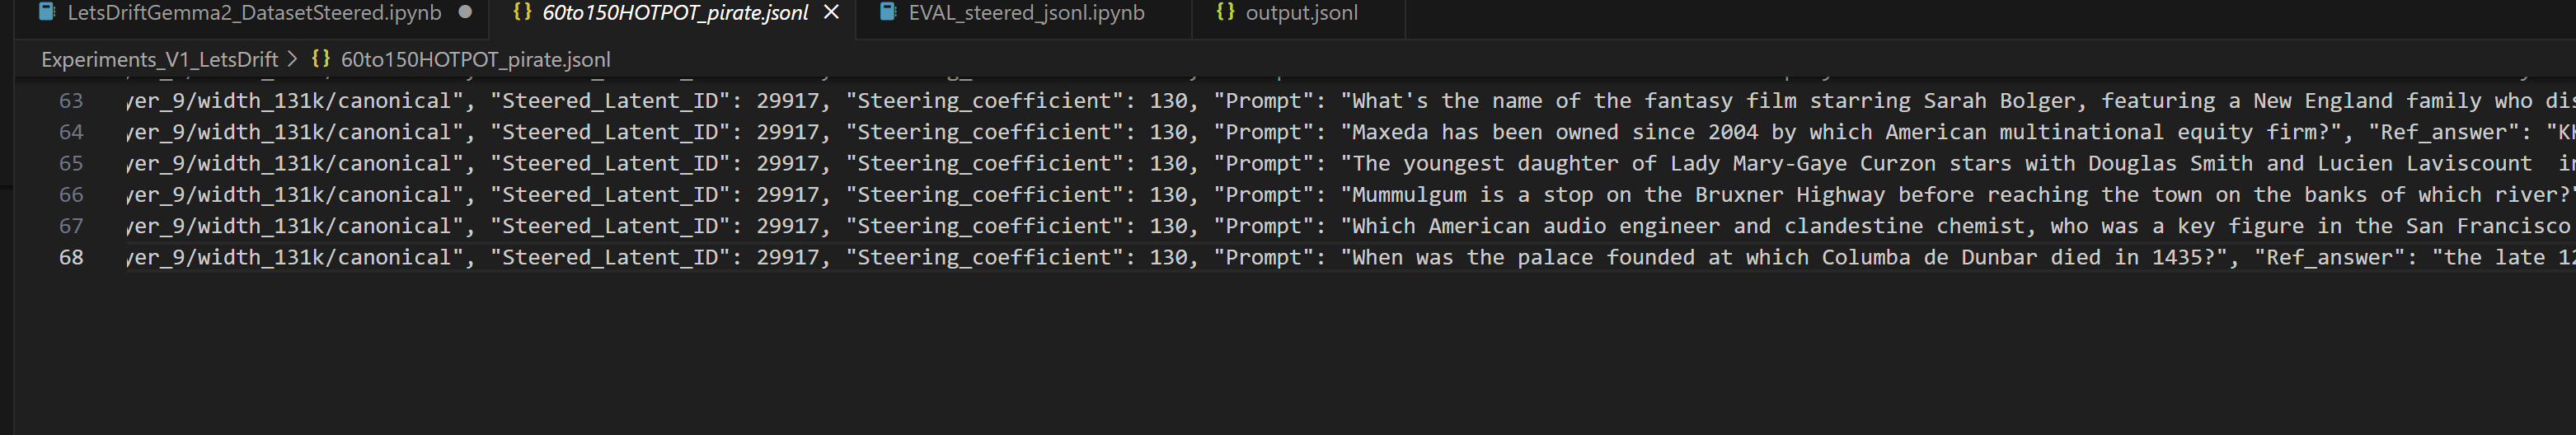

In [19]:
output_file_name = "60to150HOTPOT_pirate.jsonl"

outer_pbar = tqdm(range(max_queries-68), desc="Running through eval dataset") #! -67 because I already did the first 67.....
inner_pbar = tqdm(total=num_steered_examples+1, desc=" ⤷ Generating steered examples", leave=False)  # assuming num_steered_examples=2
for i in outer_pbar:
    inner_pbar.reset()
    inner_pbar.refresh()  # Force refresh display 
    evaluate_with_steering(
        prompt=test_data_HP.iloc[i]['query'],
        prompt_id=i+67, 
        ref_answer= test_data_HP.iloc[i]['ref_answer'], 
        latent_id = 29917, 
        steering_coeff=130, 
        num_steered_examples=2, 
        output_file=output_file_name, 
        dataset_name="60_150HOTPOTQA", 
        incremental_temperature = True, 
        comment = "none",
        progress_bar=inner_pbar  # Pass the progress bar as parameter
        )

Running through eval dataset:   0%|          | 0/22 [00:00<?, ?it/s]

 ⤷ Generating steered examples:   0%|          | 0/3 [00:00<?, ?it/s]

Screenshot of latent 120550 from neuronpedia
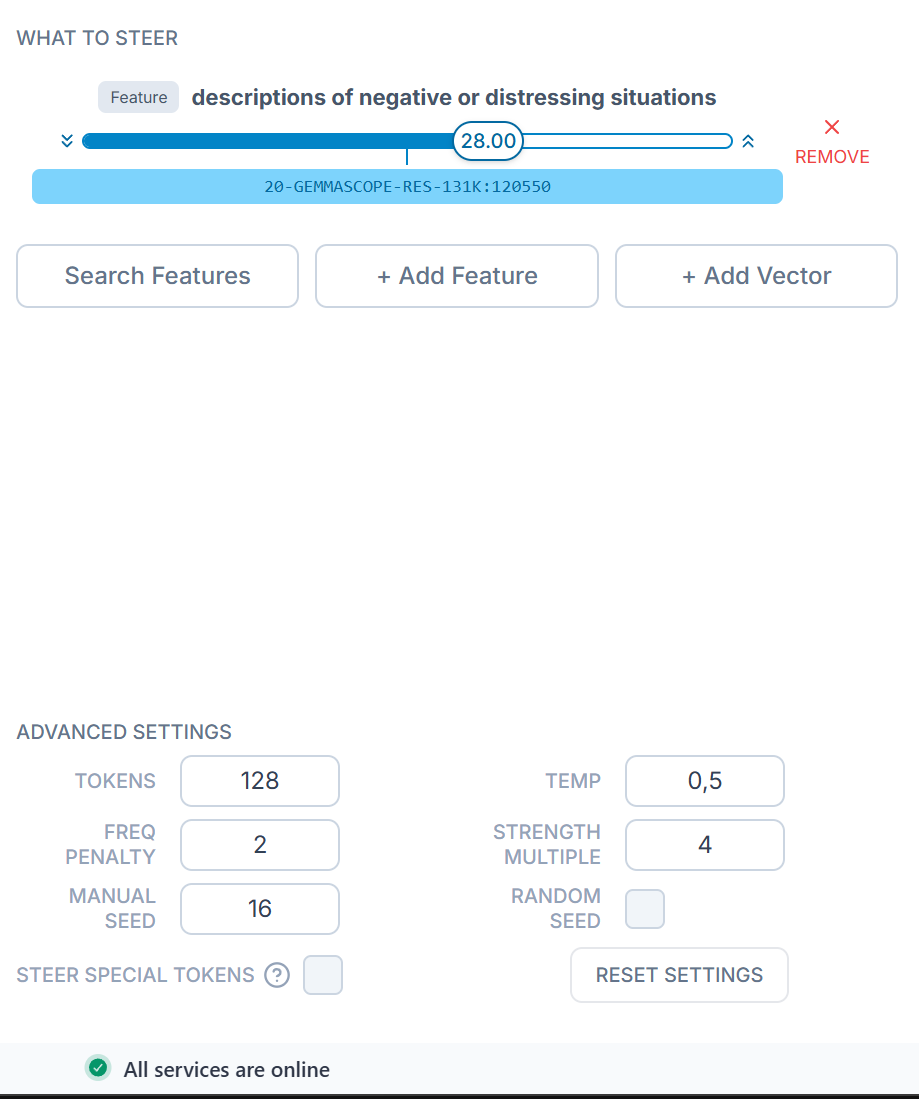

In [20]:

test_data_HP = hotpotqa_df[['query', 'ref_answer']].iloc[60:60+max_queries].copy() # 
output_file_name = "60to150HOTPOT_negative.jsonl"

outer_pbar = tqdm(range(max_queries), desc="Running through eval dataset")
inner_pbar = tqdm(total=num_steered_examples+1, desc=" ⤷ Generating steered examples", leave=False)  # assuming num_steered_examples=2
for i in outer_pbar:
    inner_pbar.reset()
    inner_pbar.refresh()  # Force refresh display 
    evaluate_with_steering(
        prompt=test_data_HP.iloc[i]['query'],
        prompt_id=i, 
        ref_answer= test_data_HP.iloc[i]['ref_answer'], 
        latent_id = 120550, #120550: Negative or distressing  
        steering_coeff=95, 
        num_steered_examples=2, 
        output_file=output_file_name, 
        dataset_name="60_150HOTPOTQA", 
        incremental_temperature = True, 
        comment = "none",
        progress_bar=inner_pbar  # Pass the progress bar as parameter
        )

Running through eval dataset:   0%|          | 0/90 [00:00<?, ?it/s]

 ⤷ Generating steered examples:   0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
output_file_name = "60to150USMLE_pirate.jsonl"
GENERATE_KWARGS["freq_penalty"] = 1.2

In [22]:


outer_pbar = tqdm(range(max_queries), desc="Running through eval dataset")
inner_pbar = tqdm(total=num_steered_examples+1, desc=" ⤷ Generating steered examples", leave=False)  # assuming num_steered_examples=2
for i in outer_pbar:
    inner_pbar.reset()
    inner_pbar.refresh()  # Force refresh display
    evaluate_with_steering(
        prompt=test_data_USM.iloc[i]['query'], 
        prompt_id=i, 
        ref_answer= test_data_USM.iloc[i]['ref_answer'], 
        latent_id = 29917, 
        steering_coeff=160, 
        num_steered_examples=num_steered_examples, 
        output_file=output_file_name, 
        dataset_name="60_150USMLE", 
        incremental_temperature = True, 
        comment = "freq penalty altered",
        progress_bar=inner_pbar  # Pass the progress bar as parameter
    )
    


Running through eval dataset:   0%|          | 0/90 [00:00<?, ?it/s]

 ⤷ Generating steered examples:   0%|          | 0/3 [00:00<?, ?it/s]

90 queries, 1300 tokens max, 2 steering examples and 1 unsteered take 460minutes (RTX3070)